In [32]:
# ======================================================
# PASO 1: Importar bibliotecas
# ======================================================

# si no contamos con ucimlrepo la instalamos
#!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
# ======================================================
# PASO 2: Cargar y preparar datos
# ======================================================

# Descargar dataset: de la siguiente página web:https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients
#=====================
creditos = fetch_ucirepo(id=350)

# Traducir nombres de variables
nombres_variables = creditos.variables.set_index("name")["description"].to_dict()

# Crear DataFrames con nombres reales
X = creditos.data.features.rename(columns=nombres_variables)
y = creditos.data.targets.rename(columns={"Y": "defaultpay"})

# Unir X e y para procesamiento
df = pd.concat([X, y], axis=1)
#Mostrar primeros 6 registros
print(df.head()) 

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  defaultpay  
0         0         0 

In [34]:
# ======================================================
# PASO 3: Limpieza de datos
# ======================================================
#Mostrar los valores faltantes
print(f"\nValores faltantes antes: {df.isnull().sum().sum()}")

# Eliminar filas con valores faltantes
df = df.dropna()
#ordena los índices despues de eliminar filas
df = df.reset_index(drop=True)
#mostrar la data eliminado los valores faltantes
print(f"Valores faltantes después: {df.isnull().sum().sum()}")


Valores faltantes antes: 0
Valores faltantes después: 0


In [35]:
# ======================================================
# PASO 4: Manejo de outliers (solo variables numéricas continuas)
# ======================================================
def eliminar_outliers(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Definir límites solo si la variable es continua
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# solo variables numéricas continuas (excluir categóricas/ordinales)
numericas_continuas = [
    'LIMIT_BAL',
    'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'
]

print(f"\nFilas antes de eliminar outliers: {len(df)}")
df = eliminar_outliers(df, numericas_continuas)  # <-- Aplicar solo a variables continuas
df = df.dropna()
print(f"Filas después de eliminar outliers: {len(df)}")


Filas antes de eliminar outliers: 30000
Filas después de eliminar outliers: 22744


In [37]:
# Contamos outliers por cada columna usando método IQR
for columna in numericas_continuas:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
 # se desea con la misma formular del limite inferior y superior contar todo los ouliers de las
 # para luego mostrarlas por cada variable
    outliers = ((df[columna] < lim_inf) | (df[columna] > lim_sup)).sum()
    print(f'Outliers en "{columna}": {outliers}')

Outliers en "LIMIT_BAL": 590
Outliers en "AGE": 0
Outliers en "BILL_AMT1": 607
Outliers en "BILL_AMT2": 513
Outliers en "BILL_AMT3": 524
Outliers en "BILL_AMT4": 298
Outliers en "BILL_AMT5": 142
Outliers en "BILL_AMT6": 184


In [38]:
# ======================================================
# PASO 5: Estadísticas descriptivas (con etiquetas claras)
# ======================================================

# Separar en grupos de variables categoricas, ordinales y continuas
categoricas = ['SEX', 'EDUCATION', 'MARRIAGE']
ordinales = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
continuas = [
    'LIMIT_BAL',
    'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'
]

print("\nClasificación de variables:")
print(f"- Categóricas: {categoricas}")
print(f"- Ordinales: {ordinales}")
print(f"- Continuas: {continuas}")


Clasificación de variables:
- Categóricas: ['SEX', 'EDUCATION', 'MARRIAGE']
- Ordinales: ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
- Continuas: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']


In [44]:
# Contar la frecuencia de cada valor único en la columna "EDUCATION"

print(df['EDUCATION'].value_counts())

EDUCATION
2    10576
1     7991
3     3869
4      308
Name: count, dtype: int64


In [45]:
# Reemplazar valores poco frecuentes (0, 5, 6) en EDUCATION por la categoría 4 (Others)
df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
# Crear tabla cruzada entre EDUCATION y defaultpay para verificar distribución
ct = pd.crosstab(df['EDUCATION'], df['defaultpay'])
print(ct)

defaultpay     0     1
EDUCATION             
1           6433  1558
2           7992  2584
3           2855  1014
4            287    21


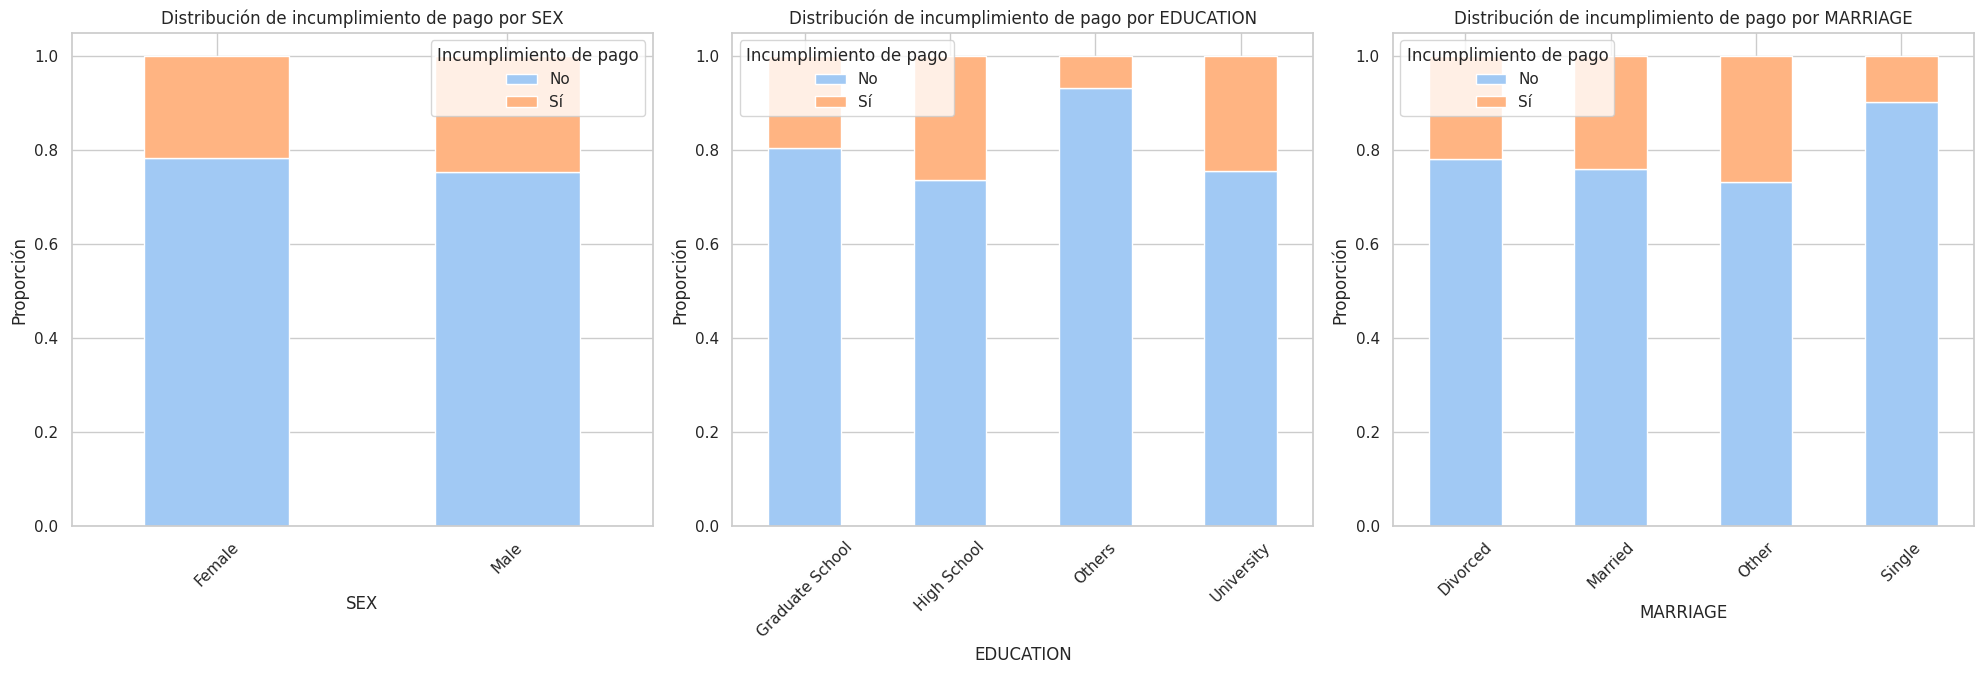

In [46]:
# ======================================================
# PASO 6: Visualización de variables categóricas
# ======================================================

# Definir tamaño y estilo del gráfico
plt.figure(figsize=(20, 25))
sns.set(style="whitegrid", palette="pastel")

# Diccionario para asignar etiquetas descriptivas a los valores numéricos
category_mapping = {
    'MARRIAGE': {0: 'Single', 1: 'Married', 2: 'Divorced', 3: 'Other'},
    'SEX': {1: 'Male', 2: 'Female'},
    'EDUCATION': {0: 'Others', 1: 'Graduate School', 2: 'University',
                  3: 'High School', 4: 'Others', 5: 'Others', 6: 'Others'}
}
# --------------------------------------
# 6.1 Crear gráficos de barras apiladas para variables categóricas
# --------------------------------------

# Iterar por cada variable categórica definida previamente
for i, col in enumerate(categoricas, 1):

    # Crear subgráficos en una cuadrícula de 4x3
    plt.subplot(4, 3, i)

    # Copiar temporalmente el dataframe original para no afectar los datos originales
    temp_df = df.copy()

    # Aplicar el mapeo si la columna actual tiene definiciones descriptivas
    if col in category_mapping:
        temp_df[col] = temp_df[col].map(category_mapping[col])

    # Generar tabla cruzada (frecuencia de incumplimiento por categoría)
    ct = pd.crosstab(temp_df[col], temp_df['defaultpay'])

    # Convertir frecuencias absolutas en proporciones relativas (porcentajes)
    ct_percent = ct.div(ct.sum(axis=1), axis=0)

    # Crear gráficos de barras apiladas (en porcentajes)
    ct_percent.plot(kind='bar', stacked=True, ax=plt.gca())

    # Añadir título, etiquetas de ejes y leyenda
    plt.title(f'Distribución de incumplimiento de pago por {col}')
    plt.xlabel(col)
    plt.ylabel('Proporción')
    plt.legend(title='Incumplimiento de pago', labels=['No', 'Sí'])
    plt.xticks(rotation=45)  # colocar la etiqueta en 45 grados para que entre la categoria

# Ajustar el diseño del gráfico para que no haya superposiciones y mostrarlo
plt.tight_layout()
plt.show()

<Figure size 2000x2500 with 0 Axes>

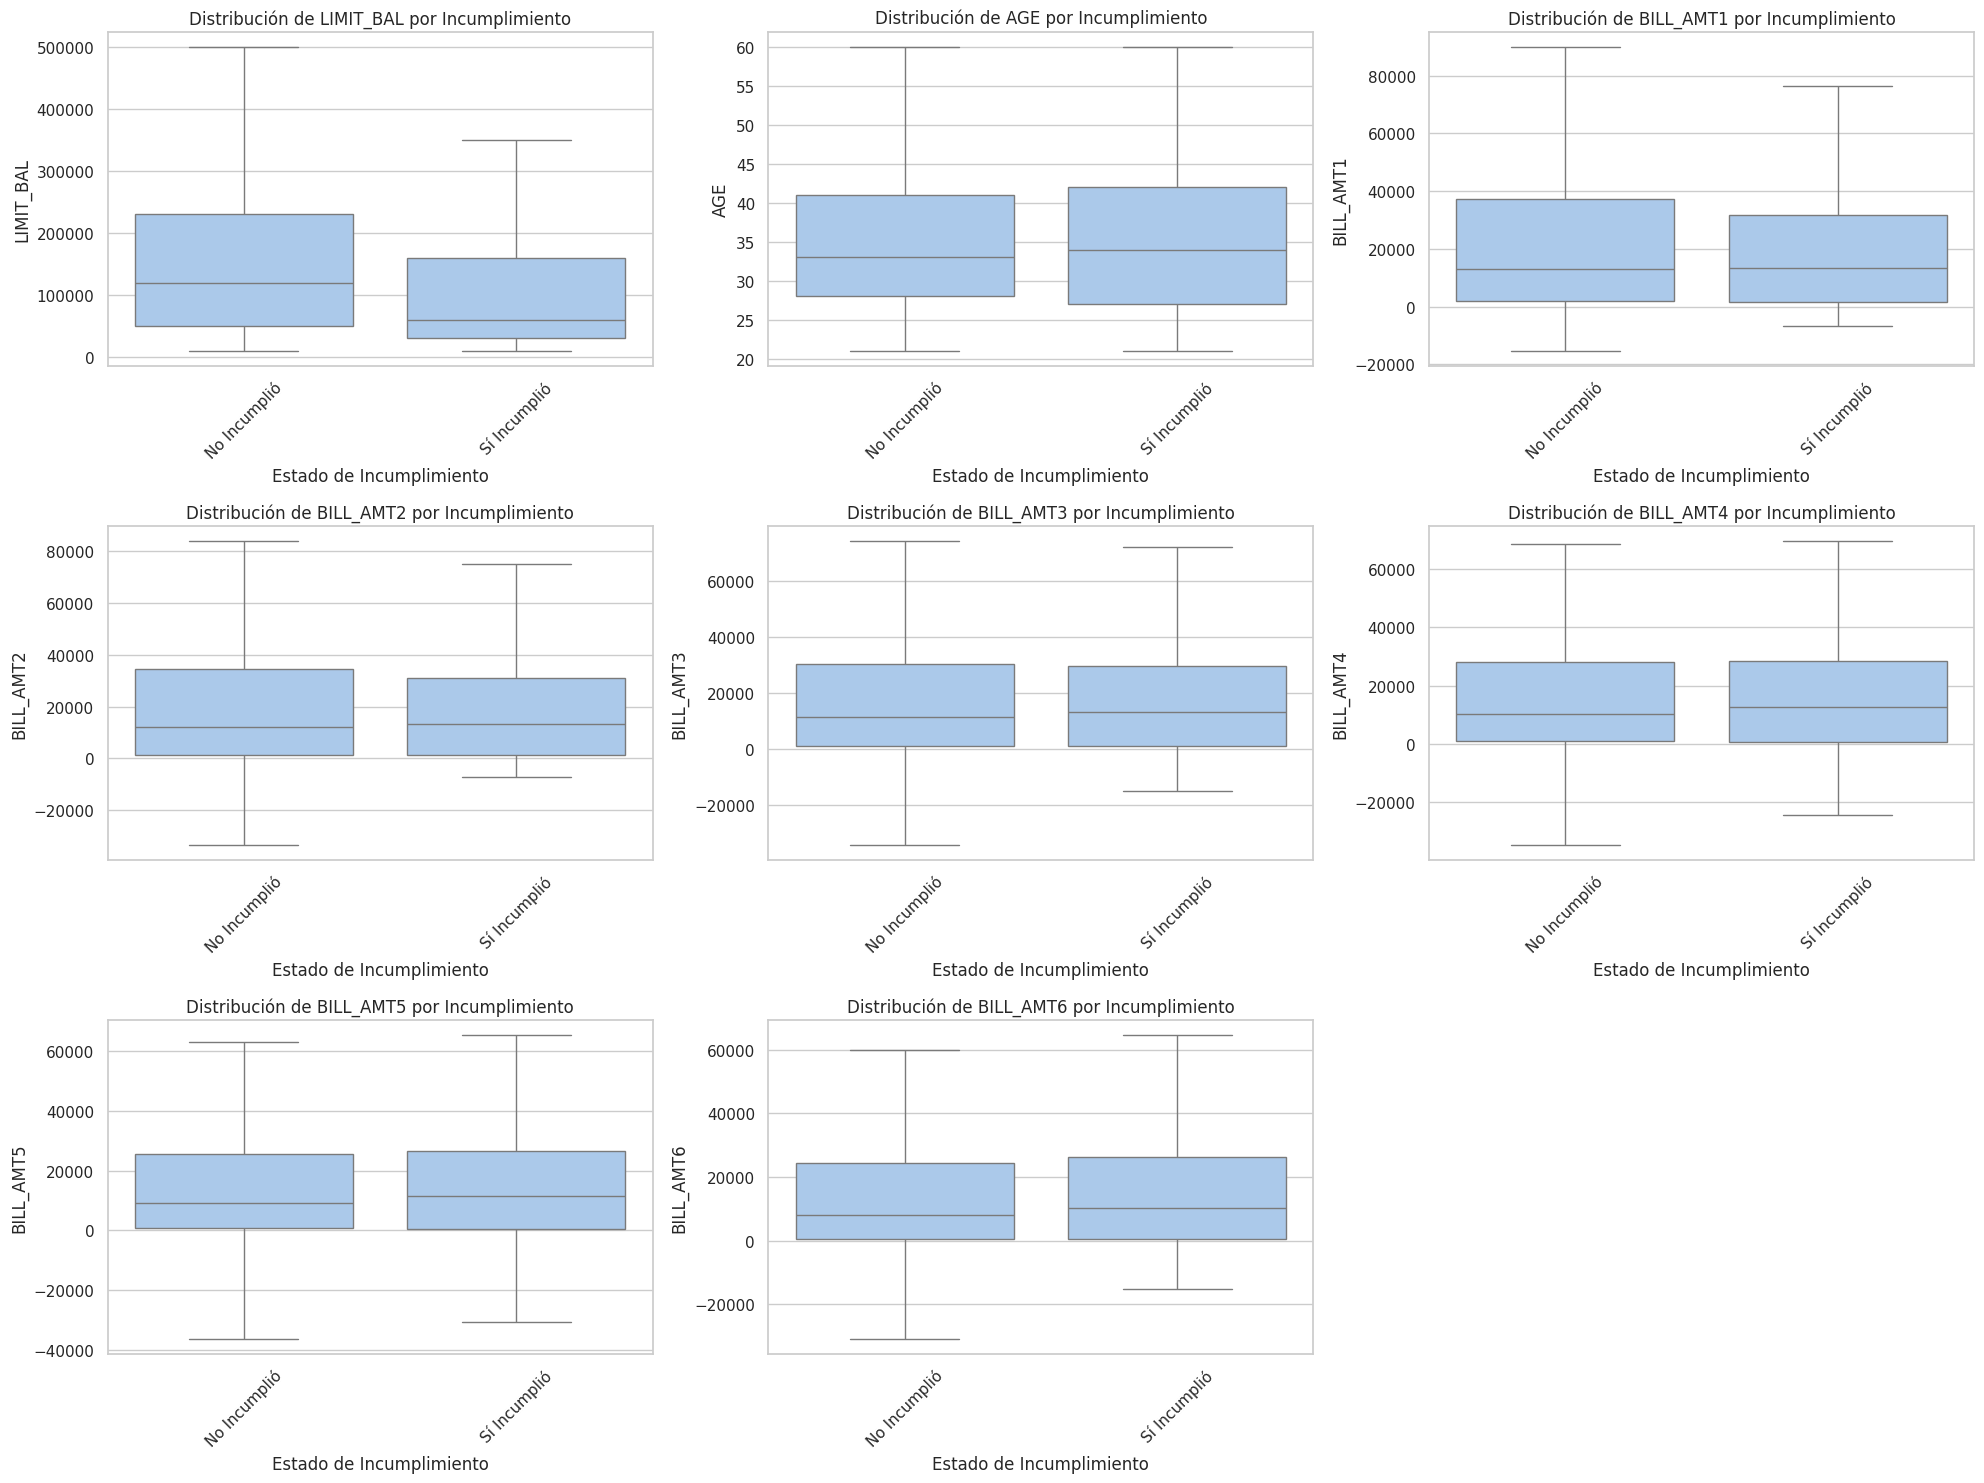

In [47]:
# ======================================================
# PASO 6: Visualización de variables numéricas
# ======================================================

# Configuración general del gráfico: tamaño y estilo visual
plt.figure(figsize=(20, 25))
sns.set(style="whitegrid", palette="pastel")

# --------------------------------------
# 6.2 Gráficos para variables numéricas (Boxplots)
# --------------------------------------

# Diccionario para convertir valores numéricos en etiquetas descriptivas para el gráfico
mapeo_default = {0: "No Incumplió", 1: "Sí Incumplió"}

# Calcular el número de filas necesarias según el número de variables numéricas a graficar
num_cols = 3  # Número de columnas en la cuadrícula de gráficos
num_rows = int(np.ceil(len(continuas) / num_cols))  # Número de filas necesarias, redondeado hacia arriba

# Ajustar el tamaño de la figura en función del número de gráficos (variables numéricas)
plt.figure(figsize=(20, 5 * num_rows))

# Bucle para generar gráficos tipo boxplot para cada variable numérica continua
for i, col in enumerate(continuas, 1):
    plt.subplot(num_rows, num_cols, i)  # Definir posición en la cuadrícula de gráficos

    # Crear boxplot (sin mostrar outliers) para comparar la distribución según la categoría "defaultpay"
    sns.boxplot(x='defaultpay', y=col, data=df, showfliers=False)

    # Añadir título y etiquetas a los ejes
    plt.title(f'Distribución de {col} por Incumplimiento')
    plt.xlabel('Estado de Incumplimiento')
    plt.ylabel(col)

    # Cambiar etiquetas numéricas por descriptivas (No Incumplió, Sí Incumplió) y rotarlas para mejor visualización
    plt.xticks(
        ticks=[0, 1],
        labels=[mapeo_default[0], mapeo_default[1]],
        rotation=45
    )

# Ajustar automáticamente los gráficos para que no se superpongan
plt.tight_layout()

# Mostrar todos los gráficos generados
plt.show()

In [48]:
# Mapeo de etiquetas
mapeo_default = {0: "No Incumplió", 1: "Sí Incumplió"}

# 6.3 Estadísticas para variables numéricas
print("\nEstadísticas descriptivas - Variables numéricas:")
print(df[continuas].describe())

# 6.4 Estadísticas para variables categóricas
print("\nFrecuencias - Variables categóricas:")
for var in categoricas:
    print(f"\nVariable: {var}")
    print(df[var].value_counts(normalize=True).sort_index())

# 6.5 Estadísticas por categoría de default (con etiquetas)
print("\nComparación por default (medias numéricas):")
df_temp = df.copy()
df_temp['defaultpay'] = df_temp['defaultpay'].map(mapeo_default)  # Aplicar mapeo
print(df_temp.groupby('defaultpay')[continuas].mean())

print("\nComparación por default (proporciones categóricas):")
for var in categoricas:
    print(f"\nVariable: {var}")
    ct = pd.crosstab(df['defaultpay'], df[var], normalize='columns')
    ct.index = ct.index.map(mapeo_default)  # Cambiar índices
    print(ct)


Estadísticas descriptivas - Variables numéricas:
           LIMIT_BAL           AGE      BILL_AMT1      BILL_AMT2  \
count   22744.000000  22744.000000   22744.000000   22744.000000   
mean   145675.870559     35.019785   22202.783503   20788.924595   
std    122182.342961      9.013625   25481.862236   23364.186256   
min     10000.000000     21.000000  -15308.000000  -67526.000000   
25%     50000.000000     28.000000    1832.000000    1426.000000   
50%    100000.000000     34.000000   13056.000000   12441.500000   
75%    210000.000000     41.000000   35735.750000   33539.000000   
max    520000.000000     60.000000  158471.000000  120651.000000   

           BILL_AMT3     BILL_AMT4     BILL_AMT5     BILL_AMT6  
count   22744.000000  22744.000000  22744.000000  22744.000000  
mean    19280.751363  17167.484084  15534.684312  14762.804344  
std     21311.152326  18662.134891  17058.890267  16771.474271  
min    -34041.000000 -34503.000000 -37594.000000 -36156.000000  
25%      115

<Axes: >

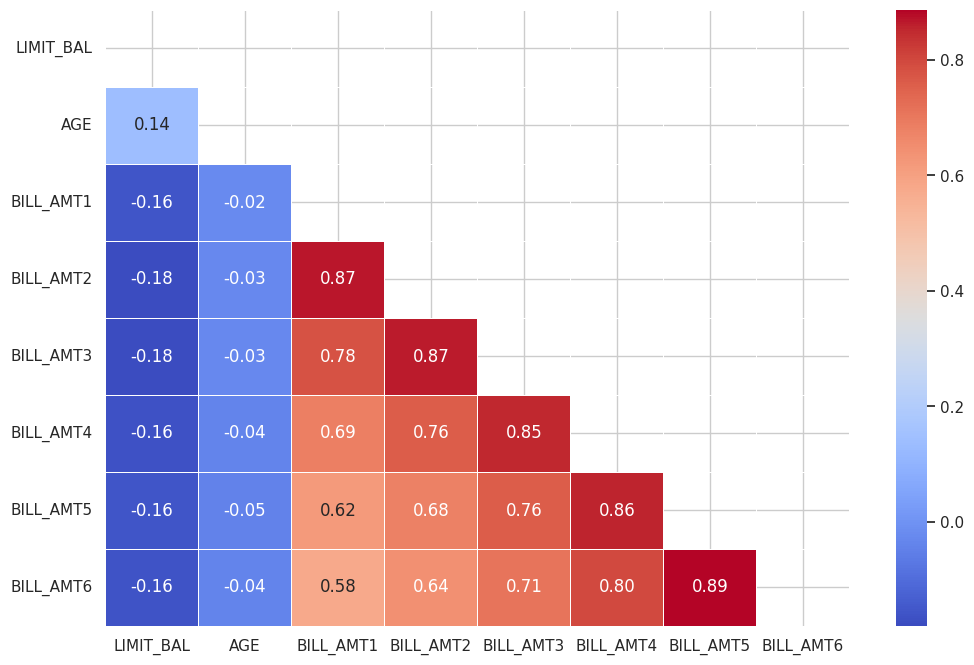

In [49]:
# Seleccionar variables cuantitativas continuas

continuas = [
    'LIMIT_BAL',
    'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'
]

# Filtrar DataFrame
df_continuas = df[continuas]

# Calcular matriz de correlación
corr_matrix = df_continuas.corr()

# Visualizar con heatmap
plt.figure(figsize=(12, 8))  # Configurar el tamaño de la figura (ancho: 12 pulgadas, alto: 8 pulgadas)

sns.heatmap(
    corr_matrix,                # Matriz de correlación a visualizar
    annot=True,                 # Mostrar valores numéricos dentro de cada celda
    cmap='coolwarm',            # Mapa de colores: rojo (correlación +1), azul (-1)
    fmt=".2f",                 # Formatear números anotados a 2 decimales
    linewidths=0.5,             # Grosor de las líneas entre celdas (mejora la legibilidad)
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool))  # Enmascarar el triángulo superior (incluyendo la diagonal)
    # Nota: np.triu() crea una matriz triangular superior de 1s, lo que oculta la mitad redundante de la matriz
)
